# A Least-Squares Filter for Sequence-Space Models

This notebook is a companion to the note "A Least-Squares Filter for Sequence-Space Models", available at [rodolforigato.com](https://www.rodolforigato.com/).

If you have any questions or suggestions, feel free to contact me. My contact information can be found on my website above.

Start by importing the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sequence_jacobian.examples import two_asset
from scipy.linalg import cho_factor, cho_solve

This is the main function of this notebook:

In [2]:
def filter(data, irf, sigma):
    """
    Filter unobserved shocks in sequence-space models

    Parameters
    ----------
    data: dictionary containing the paths of observable variables
    irf: nested dictionary containing the IRFs of observables, i.e.,
         irf[o][s] is the IRF of observable o w.r.t. shock s
    sigma: dictionary containing shock standard deviations
    
    Returns:
    --------
    e: dictionary of filtered shock paths
    """

    # back out observables and shock names from irf
    observables = list(irf.keys())
    shocks = list(irf[observables[0]].keys())

    # back out IRF and sample size
    T = len(data[observables[0]])
    T_irf = len(irf[observables[0]][shocks[0]])
    
    # build the X matrix as in the note
    X = {i: {j: np.zeros((T, T + T_irf - 1)) for j in shocks} for i in observables}

    for i in observables:
        for j in shocks:
            x_flipped = np.flip(irf[i][j])
            Xij = np.zeros((T, T + T_irf - 1))

            for t in range(T):
                Xij[t, t: t + T_irf] = x_flipped
            
            X[i][j] = Xij

    X_stacked = np.block([[X[i][j] for j in shocks] for i in observables])

    # stack the data into a vector
    y_stacked = np.concatenate([data[i] for i in observables])

    # find any missing values to drop
    keep = np.where(~np.isnan(y_stacked))[0]

    # drop the rows of X and y where values are missing
    y_stacked = y_stacked[keep]
    X_stacked = X_stacked[keep, :]

    # stack the shock standard deviations over time
    # to handle heteroskedastic shocks, make sig[s] a time-varying path
    sig_stacked = np.concatenate([sigma[s] * np.ones(T + T_irf - 1) for s in shocks])

    Sig_XT = (sig_stacked[:, np.newaxis] ** 2) * X_stacked.T
    X_Sig_XT = X_stacked @ Sig_XT

    # use Cholesky factorization to solve fast
    F = cho_factor(X_Sig_XT)
    e_stacked = Sig_XT @ cho_solve(F, y_stacked)

    # put shocks in a dictionary
    e = {s: e_stacked[k * (T + T_irf - 1): (k + 1) * (T + T_irf - 1)][-T:] for k, s in enumerate(shocks)}

    return e

Let's use as example the two-asset model from the SSJ toolbox (see Auclert, Bardoczy, Rognlie and Straub, 2021)

In [3]:
two_asset_model_ss, ss, two_asset_model, unknowns, targets, exogenous = two_asset.dag()

T_irf = 300  # truncation horizon for IRFs
J = two_asset_model.solve_jacobian(ss, unknowns, targets, exogenous, T=T_irf)  # solve the model

The model features three exogenous shocks. Let's assume each one follows an AR(1) process with 0.8 persistence. Let's also define a list of observable variables, a dictionary with shock standard deviations, and compute IRFs in the correct format for the filtering function.

In [4]:
observables = ['Y', 'pi', 'i']  # use as observables output, inflation and the short-term nominal interest rate
shocks = ['rstar', 'Z', 'G']  # use as shocks the 3 exogenous variables from the model

# common persistence and shock standard deviations
persistence = 0.8
sigma = {
    'rstar': 0.1,
    'Z': 0.2,
    'G': 0.5
}

# specify the IRFs as a nested dictionary, i.e., irf[o][s] is the IRF of observable o w.r.t. shock s
irf = {o: {s: J[o][s] @ (persistence ** np.arange(T_irf)) for s in shocks} for o in observables}

Now let's define a function that simulates paths for observable variables given the IRFs. It is possible to make this function faster using numba, if necessary.

In [5]:
def simulate_paths(irf, T):
    # dictionary of shock paths
    shock_paths = {s: sigma[s] * np.random.randn(T + T_irf - 1) for s in shocks}

    paths = {o: np.zeros(T + T_irf - 1) for o in observables}

    for o in observables:
        for s in shocks:
            for t in range(T + T_irf - 1):
                paths[o][t: min(t + T_irf, T + T_irf - 1)] += shock_paths[s][t] * irf[o][s][:min(T_irf, T + T_irf - 1 - t)]
        
        # keep only the last T periods
        paths[o] = paths[o][-T:]

    paths.update({s: shock_paths[s][-T:] for s in shocks})  # add shock paths

    return paths


Let's simulate and plot the data.

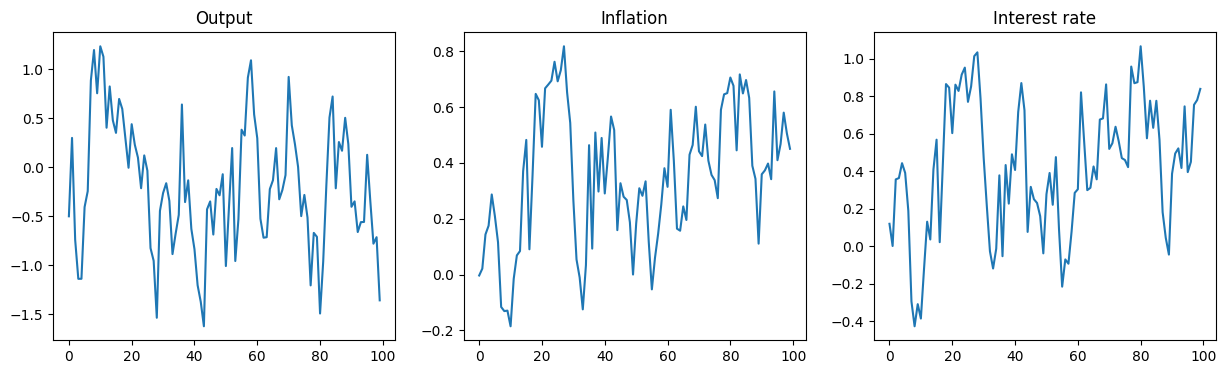

In [6]:
T = 100  # sample size
np.random.seed(0)  # fix the seed to results don't vary

data = simulate_paths(irf, T)

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
ax[0].plot(data['Y'])
ax[0].set_title('Output')

ax[1].plot(data['pi'])
ax[1].set_title('Inflation')

ax[2].plot(data['i'])
ax[2].set_title('Interest rate')
plt.show()


Finally, let's filter the shocks from the simulated data and compare with the simulated paths

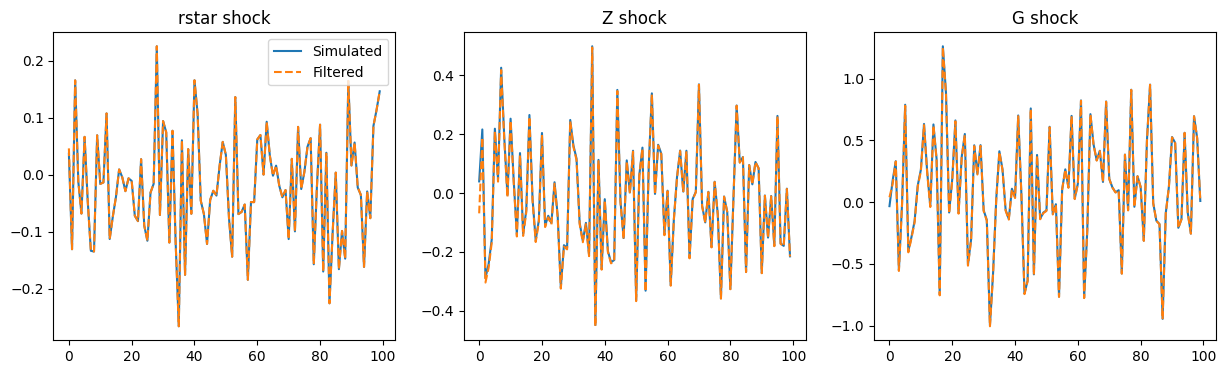

In [7]:
e_filtered = filter(data, irf, sigma)

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
ax[0].plot(data['rstar'])
ax[0].plot(e_filtered['rstar'], '--')
ax[0].set_title('rstar shock')
ax[0].legend(['Simulated', 'Filtered'])

ax[1].plot(data['Z'])
ax[1].plot(e_filtered['Z'], '--')
ax[1].set_title('Z shock')

ax[2].plot(data['G'])
ax[2].plot(e_filtered['G'], '--')
ax[2].set_title('G shock')

plt.show()